This is how much space the figure will take up on letter paper


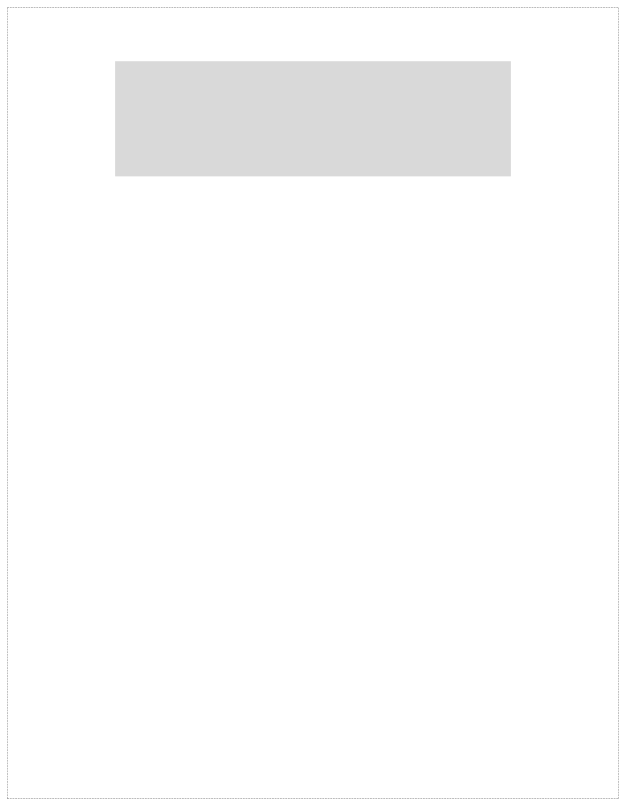

In [1]:
__PRODUCTION__ = 1
__NAME__       = 'sbm'
__WIDTH__      = 5.5  # NeurIPS 2021 text box width
__HEIGHT__     = 1.6

if __PRODUCTION__:
    from mplmagic import pgf
else:
    from mplmagic import svg

from mplmagic.util import SuperFigure, SuperAxes, size_hint
import matplotlib.pyplot as plt

print('This is how much space the figure will take up on letter paper')
size_hint(__WIDTH__, __HEIGHT__, margin_left=0.5 * (8.5 - __WIDTH__));

In [2]:
import functools
import numpy as np
import colorsys
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import networkx as nx

from symfac.experimental import RBFExpansionV2

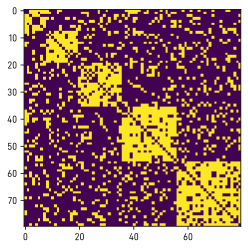

In [3]:
# sizes = [16, 32, 48, 64, 80]
sizes = 4 * np.arange(2, 7)
n = np.sum(sizes)
p1 = 0.8
p2 = 0.2
probs = [[p1, p2, p2, p2, p2], [p2, p1, p2, p2, p2], [p2, p2, p1, p2, p2], [p2, p2, p2, p1, p2], [p2, p2, p2, p2, p1]]
A = nx.stochastic_block_model(sizes, probs, seed=0)
K = torch.tensor(
    nx.to_numpy_array(A),
    dtype=torch.float32
)

plt.imshow(K)
plt.show()

0.2068634


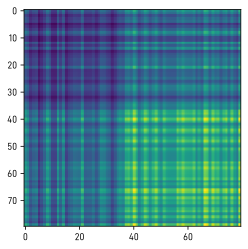

In [4]:
U, S, V = np.linalg.svd(K.numpy())
K_svd1 = torch.tensor((U[:, :1] * S[None, :1]) @ V[:1, :])
plt.imshow(K_svd1)
print(round(float(F.mse_loss(torch.tensor((U[:, :1] * S[None, :1]) @ V[:1, :]), K)), 8))

0.14807934


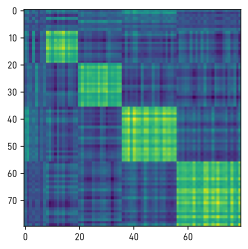

In [5]:
U, S, V = np.linalg.svd(K.numpy())
svd_approx_5 = torch.tensor((U[:, :4] * S[None, :4]) @ V[:4, :])
plt.imshow(svd_approx_5)
print(round(float(F.mse_loss(svd_approx_5, K)), 8))

0.13955757


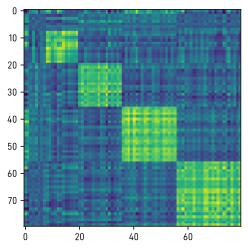

In [6]:
U, S, V = np.linalg.svd(K.numpy())
svd_approx_5 = torch.tensor((U[:, :5] * S[None, :5]) @ V[:5, :])
plt.imshow(svd_approx_5)
print(round(float(F.mse_loss(svd_approx_5, K)), 8))

100%|██████████| 10000/10000 [00:19<00:00, 522.64it/s]


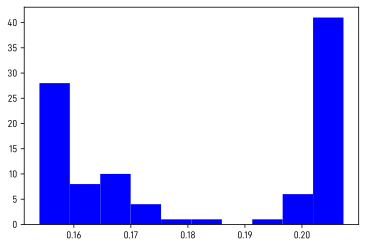

tensor(0.1540)


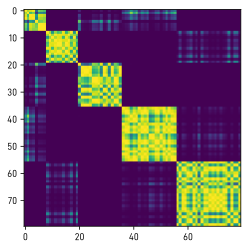

[tensor(0.1540)]


In [7]:
errors = []
k = 1
bs = 100
u0 = 1 /1000*torch.randn([bs, len(K), 1], device="cuda") 
a = torch.randn([bs, 1], device="cuda")
b = torch.randn([bs], device="cuda")
fac = RBFExpansionV2(k=k, batch_size=bs, max_steps=10000)
fac.fith(
    K,
    u0=u0,
    a0=a,
    b0=b
  )
plt.hist(fac.report.loss_best, color='b', label='1')
plt.show()

plt.show()
error = fac.report.loss_best
print(torch.min(error))
errors.append(torch.min(error))
plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
plt.show()
print(errors)


In [8]:
fac.to_pickle(f'data/{__NAME__}-1-component.pickle')

In [9]:
best_run = torch.argmin(fac.report.loss_best)
best_run

tensor(1)

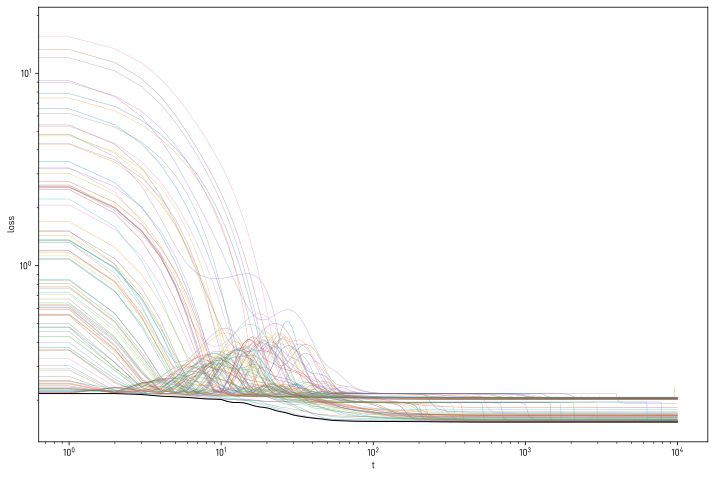

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(
    fac.report.loss_history_ticks,
    fac.report.loss_history,
    lw=0.5,
    alpha=0.5,
)
plt.plot(
    fac.report.loss_history_ticks,
    fac.report.loss_history.min(axis=1),
    lw=1,
    color='k'
)


plt.xlabel('t')
plt.ylabel('loss')
plt.xscale('log')
plt.yscale('log')
plt.show()

/home/symfac/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/symfac/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:90: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)


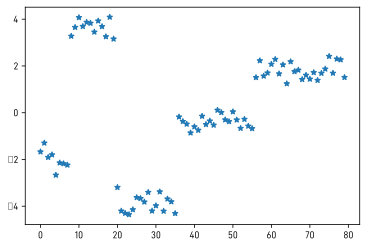

In [11]:
plt.plot(fac.report[0][0][best_run,:,:].cpu(), '*')

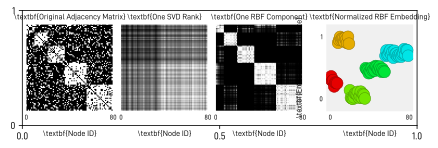

In [12]:
fig = SuperFigure(plt.figure(figsize=(__WIDTH__, __HEIGHT__), dpi=300))
ax_canvas = fig.make_axes(
    left=0, right=1, top=0, bottom=1, zorder=-100,
    style='blank' if __PRODUCTION__ else None
)
ax_canvas.set_xlim([0, 1])
ax_canvas.set_ylim([0, 1])

# draw the axes grid
x0 = 0.01
dx = 0.24
w = 0.22
axs = [
    fig.make_axes(
        left=x0 + dx * i,
        width=w,
        top=0.12,
        width_to_height=1.0,
        style='modern'
    ) for i in range(4)
]
bbox = axs[3].get_position()
bbox.x0 += 0.04
bbox.x1 += 0.04
axs[3].set_position(bbox)

best_run = torch.argmin(fac.report.loss_best)

image_styles = dict(
    cmap='Greys_r'
)
axs[0].imshow(K, **image_styles)
axs[1].imshow(K_svd1, **image_styles)
axs[2].imshow(fac.optimum(runs=best_run), **image_styles)

tick_style = dict(
    fontsize=7
)
for ax in axs[:3]:
    ax.patch.set_facecolor('w')
    ax.set_xbound(lower=0, upper=K.shape[0])
    ax.set_ybound(lower=0, upper=K.shape[1])
    xticks = np.array([0, K.shape[0]])
    ax.set_xticks(xticks)
    ax.set_yticks([])
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels(['%d' % x for x in xticks], **tick_style)
    # ax.set_yticklabels(['%d' % y for y in K.shape[1] - yticks], **tick_style)
    ax.set_xlabel(r'\textbf{Node ID}', fontsize=8, va='bottom')

starts = np.concatenate(([0], np.cumsum(sizes)))
u = fac.optimum.u[best_run, :, 0].cpu().numpy()
u = (u - u.min()) / (u.max() - u.min())  # normalize to 0-1
for i, (beg, end) in enumerate(zip(starts[:-1], starts[1:])):
    axs[3].scatter(
        np.arange(beg, end),
        u[beg:end],
        s=8.0,
        marker='o',
        color=colorsys.hls_to_rgb(i * 0.125, 0.45, 1.0),
        # edgecolor='w',
        edgecolor=colorsys.hls_to_rgb(i * 0.125, 0.3, 1.0),
        linewidth=.5
    )
axs[3].set_ylabel(r'\textbf{Embedded Coordinate}', fontsize=8)
axs[3].set_xbound(lower=-4, upper=K.shape[0] + 4)
axs[3].set_ybound(lower=-0.2, upper=1.2)
xticks = np.array([0, K.shape[0]])
axs[3].set_xticks(xticks)
axs[3].set_yticks([0, 1])
axs[3].tick_params(axis='both', which='both', length=0)
axs[3].set_xticklabels(['%d' % x for x in xticks], **tick_style)
axs[3].set_yticklabels([0, 1], **tick_style)
axs[3].set_xlabel(r'\textbf{Node ID}', fontsize=8, va='bottom')

title_style = dict(
    fontsize=8,
    y=0.975,
    va='bottom'
)
axs[0].set_title(r'\textbf{Original Adjacency Matrix}', **title_style)
axs[1].set_title(r'\textbf{One SVD Rank}', **title_style)
axs[2].set_title(r'\textbf{One RBF Component}', **title_style)
axs[3].set_title(r'\textbf{Normalized RBF Embedding}', **title_style)


if __PRODUCTION__:
    fig.savefig(f'pgf/{__NAME__}.pgf', dpi=300)
else:
    fig.savefig(f'svg/{__NAME__}.svg', dpi=300)
plt.show()

In [13]:
!make -f Makefile.figures fig-"$__NAME__".pdf 2>&1 | tail -n 1

make: 'fig-sbm.pdf' is up to date.


In [14]:
# errors = []
# k=2
# bs=100
# u0=1/1000*torch.randn([bs, 150, 1], device="cuda") 
# a=torch.randn([bs, 1], device="cuda")
# b=torch.randn([bs], device="cuda")
# fac = RBFExpansionV2(k=k, batch_size=bs, max_steps=10000)
# fac.fith(
#     K1,
#     u0=u0,
#     a0=a,
#     b0=b
#   )
# plt.hist(fac.report.loss_best, color='b', label='1')
# plt.show()

# plt.show()
# error = fac.report.loss_best
# print(torch.min(error))
# errors.append(torch.min(error))
# plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
# plt.show()
# print(errors)

END
---